# AutoMM for Entity Extraction with Text and Image



In [ ]:
!pip install autogluon.multimodal
!pip install --upgrade torchvision


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.4/60.4 kB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.0/138.0 kB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 3.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 8.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 259.5/259.5 kB 24.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
INFO: pip is looking at multiple versions of openxlab to determine which version is compatible with other requirements. This could take a while.
INFO: pip is still looking at multiple versions of openxlab to determine which version is compatible with other requirements. This could take a while.
INFO: This is taking longer than usual. You might need to provide the dependency resolver with stricter constraints to reduce runtime

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 77.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 797.1/797.1 MB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.4/209.4 MB 5.7 MB/s eta 0:00:00
  Attempting uninstall: triton
    Found existing installation: triton 2.3.1
    Uninstalling triton-2.3.1:
      Successfully uninstalled triton-2.3.1
  Attempting uninstall: nvidia-cudnn-cu12
    Found existing installation: nvidia-cudnn-cu12 8.9.2.26
    Uninstalling nvidia-cudnn-cu12-8.9.2.26:
      Successfully uninstalled nvidia-cudnn-cu12-8.9.2.26
  Attempting uninstall: torch
    Found existing installation: torch 2.3.1
    Uninstalling torch-2.3.1:
      Successfully uninstalled torch-2.3.1
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.18.1
    Uninstalling torchvision-0.18.1:
      Successfully uninstalled torchvision-0.18.1
ERR

In [ ]:
import os
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

## Get the Twitter Dataset
In the following example, we will demonstrate how to build a multimodal named entity recognition model with a real-world [Twitter dataset](https://github.com/jefferyYu/UMT/tree/master).
This dataset consists of scrapped tweets from 2016 to 2017, and each tweet was composed of one sentence and one image. Let's download the dataset.

In [ ]:
download_dir = './ag_automm_tutorial_ner'
zip_file = 'https://automl-mm-bench.s3.amazonaws.com/ner/multimodal_ner.zip'
from autogluon.core.utils.loaders import load_zip
load_zip.unzip(zip_file, unzip_dir=download_dir)

Next, we will load the CSV files.

In [ ]:
dataset_path = download_dir + '/multimodal_ner'
train_data = pd.read_csv(f'{dataset_path}/twitter17_train.csv')
test_data = pd.read_csv(f'{dataset_path}/twitter17_test.csv')
label_col = 'entity_annotations'

We need to expand the image paths to load them in training.

In [ ]:
image_col = 'image'
train_data[image_col] = train_data[image_col].apply(lambda ele: ele.split(';')[0]) # Use the first image for a quick tutorial
test_data[image_col] = test_data[image_col].apply(lambda ele: ele.split(';')[0])

def path_expander(path, base_folder):
	path_l = path.split(';')
	p = ';'.join([os.path.abspath(base_folder+path) for path in path_l])
	return p

train_data[image_col] = train_data[image_col].apply(lambda ele: path_expander(ele, base_folder=dataset_path))
test_data[image_col] = test_data[image_col].apply(lambda ele: path_expander(ele, base_folder=dataset_path))

train_data[image_col].iloc[0]

'/content/ag_automm_tutorial_ner/multimodal_ner/twitter2017_images/17_06_1818.jpg'

Each row consists of the text and image of a single tweet and the entity_annotataions which contains the named entity annotations for the text column.
Let’s look at an example row and display the text and picture of the tweet.

In [ ]:
example_row = train_data.iloc[0]

example_row

,0
text_snippet,Uefa Super Cup : Real Madrid v Manchester United
image,/content/ag_automm_tutorial_ner/multimodal_ner...
entity_annotations,"[{""entity_group"": ""B-MISC"", ""start"": 0, ""end"":..."


Below is the image of this tweet.

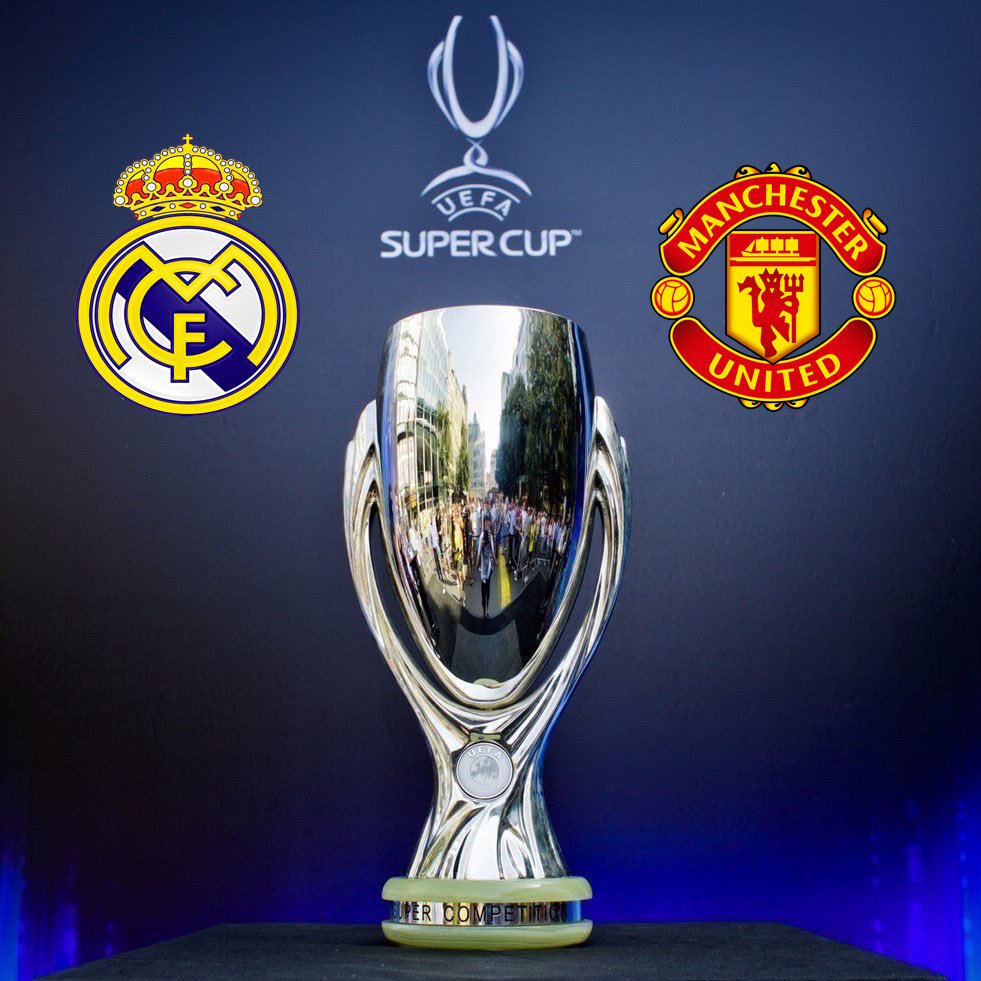

In [ ]:
example_image = example_row[image_col]

from IPython.display import Image, display
pil_img = Image(filename=example_image, width =300)
display(pil_img)

As you can see, this photo contains the logos of the Real Madrid football club, Manchester United football club, and the UEFA super cup. Clearly, the key information of the tweet sentence is coded here in a different modality.

## Training
Now let’s fit the predictor with the training data.
Firstly, we need to specify the problem_type to **ner**.
As our annotations are used for text columns, to ensure the model to locate the correct text column for entity extraction,
we need to set the corresponding column type to `text_ner` using the **column_types** parameter in cases where multiple text columns are present.
Here we set a tight time budget for a quick demo.

In [ ]:
from autogluon.multimodal import MultiModalPredictor
import uuid

label_col = "entity_annotations"
model_path = f"./tmp/{uuid.uuid4().hex}-automm_multimodal_ner"
predictor = MultiModalPredictor(problem_type="ner", label=label_col, path=model_path)
predictor.fit(
	train_data=train_data,
	column_types={"text_snippet":"text_ner"},
	hyperparameters={"env.per_gpu_batch_size": 2},  # Lower batch size to 2
	time_limit=300, #second
)

=================== System Info ===================
AutoGluon Version:  1.1.1
Python Version:     3.10.12
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Thu Jun 27 21:05:47 UTC 2024
CPU Count:          2
Pytorch Version:    2.4.1+cu121
CUDA Version:       12.1
Memory Avail:       10.63 GB / 12.67 GB (83.9%)
Disk Space Avail:   55.77 GB / 112.64 GB (49.5%)

AutoMM starts to create your model. ✨✨✨

To track the learning progress, you can open a terminal and launch Tensorboard:
    ```shell
    # Assume you have installed tensorboard
    tensorboard --logdir /content/tmp/7d2237bd33954cd59e9773bb2c9720f0-automm_multimodal_ner
    ```

INFO: Seed set to 0
GPU Count: 1
GPU Count to be Used: 1
GPU 0 Name: Tesla T4
GPU 0 Memory: 0.25GB/15.0GB (Used/Total)

INFO: Using 16bit Automatic Mixed Precision (AMP)
INFO: GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO: LO

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 0, global step 11: 'val_ner_token_f1' reached 0.04933 (best 0.04933), saving model to '/content/tmp/7d2237bd33954cd59e9773bb2c9720f0-automm_multimodal_ner/epoch=0-step=11.ckpt' as top 3
INFO: Time limit reached. Elapsed time is 0:05:00. Signaling Trainer to stop.


Validation: |          | 0/? [00:00<?, ?it/s]

AutoMM has created your model. 🎉🎉🎉

To load the model, use the code below:
    ```python
    from autogluon.multimodal import MultiModalPredictor
    predictor = MultiModalPredictor.load("/content/tmp/7d2237bd33954cd59e9773bb2c9720f0-automm_multimodal_ner")
    ```

If you are not satisfied with the model, try to increase the training time, 
adjust the hyperparameters (https://auto.gluon.ai/stable/tutorials/multimodal/advanced_topics/customization.html),
or post issues on GitHub (https://github.com/autogluon/autogluon/issues).




Under the hood, AutoMM automatically detects the data modalities, selects the related models from the multimodal model pools, and trains the selected models.
If multiple backbones are available, AutoMM appends a late-fusion model on top of them.

## Evaluation

In [ ]:
predictor.evaluate(test_data,  metrics=['overall_recall', "overall_precision", "overall_f1"])

Predicting: |          | 0/? [00:00<?, ?it/s]

{'overall_recall': 0.01744186046511628,
 'overall_precision': 0.016472203157172273,
 'overall_f1': 0.01694316978468055}

## Prediction

You can easily obtain the predictions by calling predictor.predict().

In [ ]:
prediction_input = test_data.drop(columns=label_col).head(1)
predictions = predictor.predict(prediction_input)
print('Tweet:', prediction_input.text_snippet[0])
print('Image path:', prediction_input.image[0])
print('Predicted entities:', predictions[0])

for entity in predictions[0]:
	print(f"Word '{prediction_input.text_snippet[0][entity['start']:entity['end']]}' belongs to group: {entity['entity_group']}")

Predicting: |          | 0/? [00:00<?, ?it/s]

Tweet: Citifield Fan View : RT @ jehnnybgoode What a gorgeous day for baseball ! Stuck in that Saturdaze . # NewYorkMets VS # Sa …
Image path: /content/ag_automm_tutorial_ner/multimodal_ner/twitter2017_images/16_05_01_360.jpg
Predicted entities: [{'entity_group': 'LOC', 'start': 10, 'end': 13}]
Word 'Fan' belongs to group: LOC
